# Computational Social Science project analysis, a.y. 2022/2023 
- **github**: `git`

## Abstract
literary copy the abstract here

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from cdlib import algorithms
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.multitest import fdrcorrection

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'wurlitzer'}


## Choice of the community detection algorithm

To display the results from either the communities detection estimation by means of the *Louvain* or *walktrap* algorithm modify the variable `current_community_algorithm` and execute the following analysis.


In [2]:
# Choose between ("Louvain", "walktrap")
current_community_algorithm = "Louvain" 
#current_community_algorithm = "walktrap" 

# load the .csv file of pre-computed community estimation run over the time under examination
community_record_filename = f"2023_{current_community_algorithm}_communities.csv"

## Initial Loading and pre-processing
The following section aims at loading and displaying those nodes which had been detected to be the most centered entities within the community they belong to. Specifically, for each graph estimated from the monthly average through the time span ranging between Janurary, 2018 to June, 2023, the Louvain community detection algorithm is performed to extract all those set of aggregated countries that tend to be clustered in a community.

Each resulting set of communities for the month currently under examination is then filtered by retaining only those communities whose number of countries included satisfied a-priori defined minimun number of items. Namely, for the present work the minimum number of items retained to consider a merged set of countries as a community is 5.

To display the results from either the communities detection estimation by means of the *Louvain* or *walktrap* algorithm modify the variable `current_community_algorithm` and execute the following analysis.

In [3]:
df = pd.read_csv(f"./communities_records/{community_record_filename}")
df["cindex"] = df["year"].apply(lambda x: str(x)) + "/" + df["month"].apply(lambda x: f"0{str(x)}" if len(str(x))==1 else str(x))
df['time'] = pd.to_datetime(df['cindex'].str.strip(), format='%Y/%m')

The top5 countries that were found to head their community more often over the 66 months period under examination are displayed as follows.

In [4]:
print("Top centered node that appears more often between Jan 2018 and Jun 2023")
top5names = df.groupby(by="node_name").month.count().sort_values(ascending=False)[0:5].index
df.groupby(by="node_name").month.count().sort_values(ascending=False)[0:5].to_frame()

Top centered node that appears more often between Jan 2018 and Jun 2023


,month
node_name,
USA,62
CHN,38
ESP,29
AUS,24
RUS,23


## Displaying through time
The following plot describes the distribution of centrality values over the time-span under examination. Each point defines whether the country of interest has been found to be the node with the higher betweenness centrality value with respect to the countries of the same community from where it was extracted.

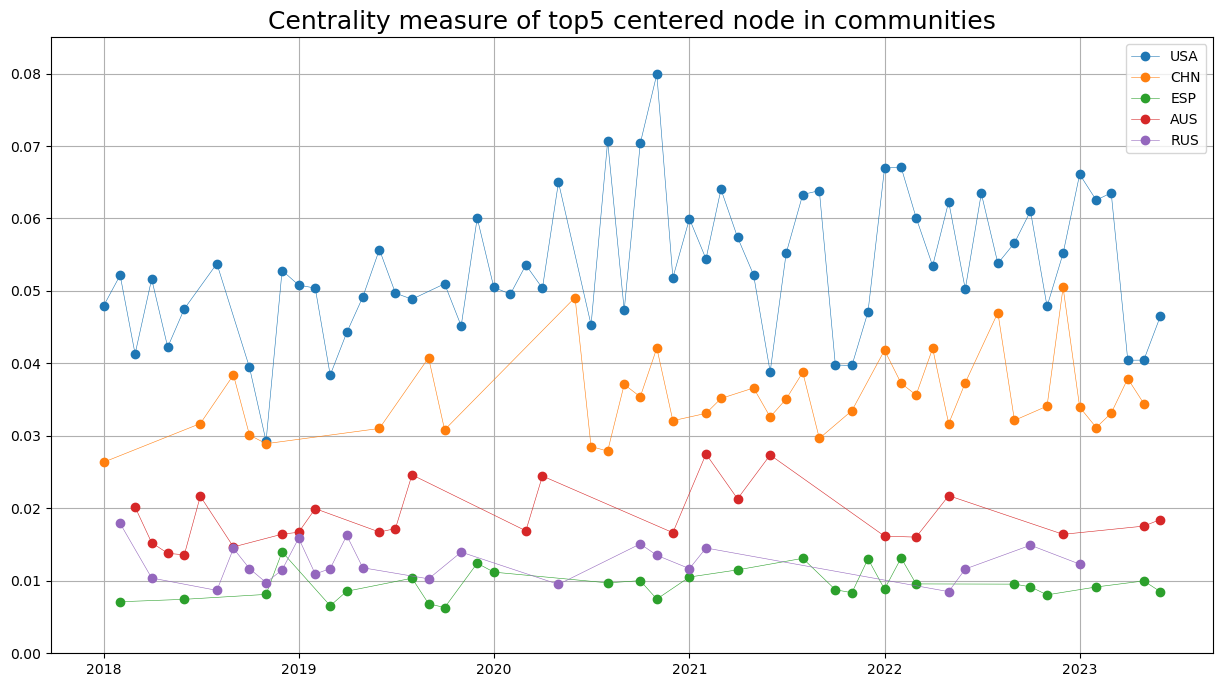

In [5]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot()
plt.grid()
for name in top5names:
    ax.plot(df[df.node_name==name].time, df[df.node_name==name].value, marker="o", linewidth=0.4, label=name)
ax.set_ylim(0,0.085)
ax.set_title("Centrality measure of top5 centered node in communities", fontsize=18)
plt.legend(loc="upper right")
plt.show()

In [6]:
current_country_name = "ITA"

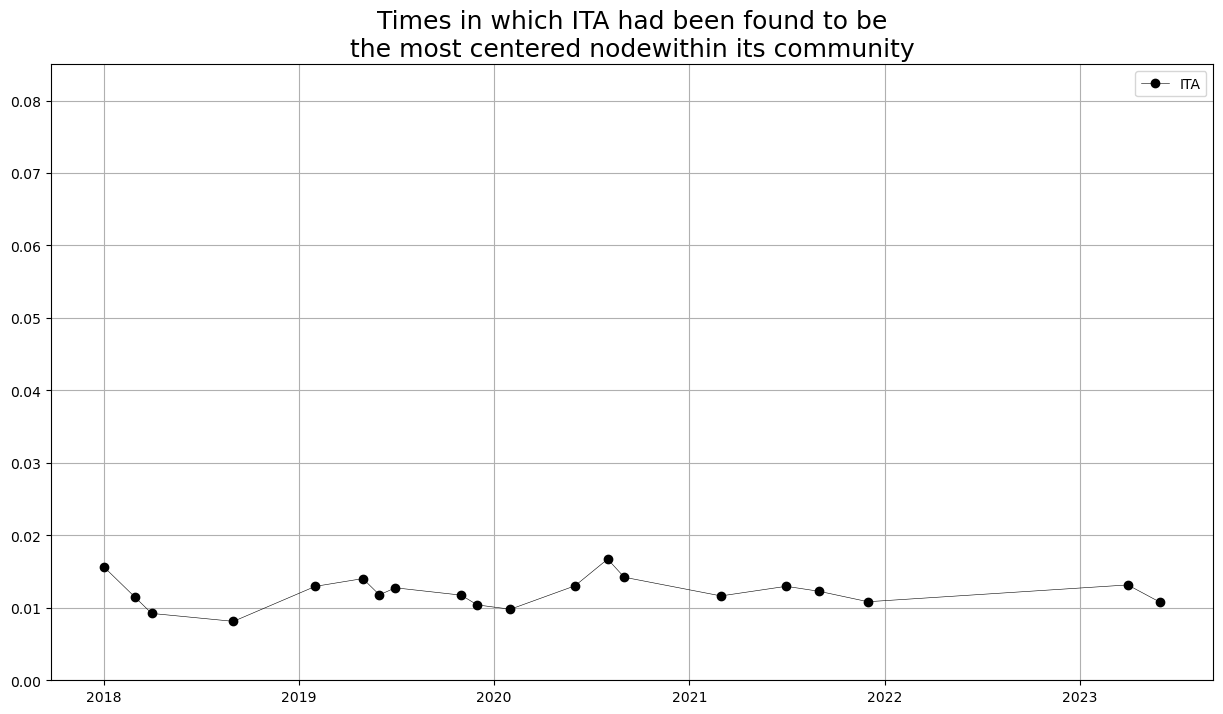

In [7]:
# displaying specific country by a given name
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot()
plt.grid()
ax.plot(df[df.node_name==current_country_name].time,
        df[df.node_name==current_country_name].value, marker="o",
        linewidth=0.4, label=current_country_name, color="black")
ax.set_ylim(0,0.085)
ax.set_title(f"Times in which {current_country_name} had been found to be\nthe most centered nodewithin its community", fontsize=18)
plt.legend(loc="upper right")
plt.show()

### Displaying the whole centrality values of top5 countries


In [8]:
# importing country list from CAMEO codes
country_list = pd.read_csv("country_codes_clean.csv", sep="\t").Alpha3_code.array.tolist()

# importing nodal values
global_list, nodal_list = [],[]
for item in os.listdir("./graph_records"):
    if item.endswith(".csv") and "global" in item:
        global_list.append(pd.read_csv(f"./graph_records/{item}"))
    elif item.endswith(".csv") and "nodal" in item:
        nodal_list.append(pd.read_csv(f"./graph_records/{item}"))
full_global, full_nodal = pd.concat(global_list).sort_values(by=["year", "month"]), pd.concat(nodal_list).sort_values(by=["year", "month"])

In [9]:
# extracting the top5 centrality measure 
top5 = df.groupby(by="node_name").month.count().sort_values(ascending=False)[0:5].index
tmp = dict()
for country in top5:
    tmp[country] = full_nodal[(full_nodal.graph_type=="A") & (full_nodal.metric_name=="BC") & (full_nodal.node==country_list.index(country))].value.reset_index().value.array

top5df = pd.DataFrame(tmp)

<Figure size 1500x800 with 0 Axes>

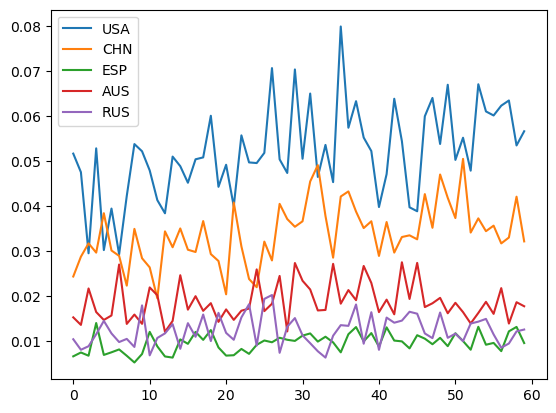

In [10]:
fig = plt.figure(figsize=(15,8))
ax = top5df.plot()
plt.show()

## Testing time-series for stationarity
In order to evaluate the mutual top5 centered countries' centrality Granger causation through time, each time-series needs to be evaluated by testing whether it is stationary or not. 
The _Augmented Dicker-Fuller_ (ADF) statistical test aims at verifing whether the current set of data can be described by an unit root (which yields the vector of observations to spread through time according to some trend) or follows a "stationary" trent, which namely implies the current time series to evolve through time with constant mean, variance and covariance over periods with identical distance.

It works by considering an Autoregressive model (AR) defined as: <br/><br/> $y_t = \rho y_{t-1} + \mu_t$ <br/><br/>
for which the resulting observation $y$ at time $t$ is defined by the product of an AR parameter $\rho$ with the observation at timestep $(t-1)$ plus an error term $u_t$ which depends on the current time-step.<br/>

According to the original Dicker-Fuller test, the regression model of the whole time-series is defined by expressing the AR model equal to the  _first difference operator_ $\Delta$ over the $t$-_th_ observation:

$\Delta y_t = (\rho - 1)y_{t-1}+\mu_t$ <br/><br/>
For which the $\Delta$ difference operator map a function $f$ to $\Delta[f]$ such that: 

$\Delta[f] = f(x+1) - f(x)$ <br/><br/>
that is usually used to approximate the derivaties of a given function in points where a change in sign occurs and, consequently, a negative or change in trend is observed after a local maximum is reached or, by contrast, a positive change in trend can be seen right after the observation at time $(t-1)$ reached a local minimum.

The ADF test improves the initial hypothesis by defining the following model:

$\Delta y_t = \alpha + \beta_t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + ... + \delta_{p-1} \Delta y_{t-p+1} + \epsilon_t$ <br/><br/>
for which an improved set of parameter is added:
- $\alpha$ : the fixed coefficient of the model.
- $\beta_t$ : the $t$-_th_ fixed coefficient.
- $\gamma$ : the weight of the observation at time-step $(t-1)$.
- $p$ : the lag order which defines the number of past timesteps to take into account to estimate the current model at time $t$.
- $(\Delta y_{t-1} + ... + \Delta y_{t-p+1})$ : is the vector of the ADF model estimates over the past $(t-p+1)$ observations.
- $(\delta_1, \delta_2, ..., \delta_{p-1})$ : weights for the previous ADF model estimates.
- $\epsilon_t$ : the $t$-_th_ error term.


The Null and Alternative hypotesis are then defined by:

- $H_0$ : $\gamma = 0$ <br/>The time-series has an unit root and any $\gamma$ is ineffective in the prediction of the current time-step observation $y_t$.<br/>
- $H_1$ : $\gamma < 0$ <br/>The time-series is stationary and $y_t$ can be predicted by the lagged value of the past $(t-1, ..., t-p+1)$ observations and, consequently, it converges to the mean of the series.<br/>

Finally, the aim of the current test is to evaluate the Dicker-Fuller estimate defined by:

$DF_{\gamma} = \frac{\hat{\gamma}}{SE(\hat{\gamma})}$

meaning that the lower the Dicker-Fuller estimate the higher the chance of rejecting the Null hypotesis.

In [11]:
# Testing time stationarity
print("Testing for time-series stationarity:")
station_pvals = []
for country in top5:
    re = adfuller(full_nodal[(full_nodal.graph_type=="A") \
                             & (full_nodal.metric_name=="BC") \
                             & (full_nodal.node==country_list.index(country))].value.reset_index().value.array)
    station_pvals.append(re[1])
    print(f"Country: {country}\tDF-estimate: {round(re[0],3)}\tp-value: {round(re[1],14)} {'***' if re[1]<0.001 else ''}")

Testing for time-series stationarity:
Country: USA	DF-estimate: -6.018	p-value: 1.5200597e-07 ***
Country: CHN	DF-estimate: -5.465	p-value: 2.4677967e-06 ***
Country: ESP	DF-estimate: -6.391	p-value: 2.106273e-08 ***
Country: AUS	DF-estimate: -8.505	p-value: 1.2e-13 ***
Country: RUS	DF-estimate: -7.902	p-value: 4.17e-12 ***


Each country's centrality time series reached the level of significance in the ADF test given the currently selected **community detection algorithm**, allowing to reject the Null Hypotesis which assumes the non-stationarity of the series.

## Testing Granger Causality

Granger Causality had been originally proposed to explain whether a time-series may be used to forecast the observations that occur in another set of observations given a fixed time-lag parameter. 

It relies on the assumption that a variable $X$ is said to Granger Cause another time-series $Y$ when

$\mathbb{P}{[Y(t+1) \in M \mid I(t)]} \neq \mathbb{P}{[Y(t+1) \in M \mid I_{-x}(t)]}$ 

that can be read as: the probability of having a forecasting prediction of $Y(t+1)$ for all elements of a given set $M$ given a set of available information $I(t)$ is different with respect to the same probability considering the set of all available information ($I_{-x}(t)$) excluding the timeseries $X$.

The initial autoregression model on $y$ can be written as:

$y_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... + \beta_m y_{t-m} + \epsilon_t$

for which the present $y_t$ observation is explained by all the previous $(t-m)$ observation weighted by a factor $\beta = (1, ... , m)$ plus an error term $\epsilon_t$.

The model is then enhanced by including the information from the first variable $x$:

$y_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... + \beta_m y_{t-m} + \lambda_p x_{t-p} + ... + \lambda_q x_{t-q} + \epsilon_t$

for that all lagged values of $x$ for a given $p$ (shortest) and $q$ longest lag length, that were found to be significant according to their t-statistic are included right after having tested that all newely added variables are improving the explanatory power to the current model by an F-test.

The null and alternative hypotesis given two time series ($X$, $Y$) are defined as follows: 
- $H_0$ : $X$ does not Granger Cause $Y$
- $H_1$ : $X$ Granger Causes $Y$

and the Null hypotesis is confirmed only if no lagged values are retained in the regression, meaning that no F-test yielded any significant result for each lag involved.

## Hypotesis

The current project aims at veryfing how the top 5 centered leading countries can be mutually influenced through time by means of evaluating the values of centrality. One may advance the assumption for which the higher the centrality measure of a given node within it's own community of reference the more likely that country is to behave like the leading entity within the circle of its closest partners. However providing assumptions on how changes in the centrality measure of a given subject may influence other leading countries is far from being trivially formulated.

One may state that the centrality trend change of the most centered nodes within their relative communities can be associated or, eventually, forecast the centrality value of other leading top centered nodes by the following speculations.

The more centrality the top centered node gains through time, the more is expected to centralize the closest neighbours by ensuring the most distal node in the community to converge towards itself rather than adhering to other most influencial top centered nodes within the remaining communities. Besides, if any given leading node within a community tends to lose centrality one can state that the less involved it becomes in contries information exchange the more the distal nodes are likely to be influenced by other communities.

The resulting scenario may be set by considering either as composed by completely segregated communities which are higly persuaded to exchange information towards the current head of the countries alliance or by widely spread set of communities for which top centered nodes are playing a minor role in the alliance attraction. In other terms, the trend of a given countries'community to caslte itself should be enhanced and, eventually, forecasted by the propension of a competitor cluster to merged and segregate. By contrast the lower the inter-countries tension the lower the need for reling to the most leading node by countries belonging to each factions involved yielding therefore a set of less centered countries alliances.

This may naively simulate the dynamics that occur between major international players in international crisis events by simply mimicking the converging trend of the country's foreing politics to satisfy the expectations moved by more influential countries. 

The **hypotesis** can be formalize as follows:
- the higher the centrality measure over time of a node the higher the competitors nodes' centrality within their relative communities and, consequently,
- the lower the centrality measure over time of a node, the lower the need of competitor's node to enhance their influence over neighbouring nodes, thus the lower its own centrality.


In [12]:
# extracting Granger Causality F-test probabilities
n = top5.shape[0]
max_lag = 1
gc_mat = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        c1, c2 = top5[i], top5[j] 
        print(c1, c2, end="\n")
        gc_mat[i,j] = grangercausalitytests(top5df[[c1, c2]], maxlag=[max_lag])[max_lag][0]["ssr_ftest"][1] if c1 != c2 else 1

USA USA
USA CHN

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9458  , p=0.0519  , df_denom=56, df_num=1
ssr based chi2 test:   chi2=4.1572  , p=0.0415  , df=1
likelihood ratio test: chi2=4.0173  , p=0.0450  , df=1
parameter F test:         F=3.9458  , p=0.0519  , df_denom=56, df_num=1
USA ESP

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5023  , p=0.4814  , df_denom=56, df_num=1
ssr based chi2 test:   chi2=0.5292  , p=0.4669  , df=1
likelihood ratio test: chi2=0.5268  , p=0.4679  , df=1
parameter F test:         F=0.5023  , p=0.4814  , df_denom=56, df_num=1
USA AUS

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1306  , p=0.7192  , df_denom=56, df_num=1
ssr based chi2 test:   chi2=0.1376  , p=0.7107  , df=1
likelihood ratio test: chi2=0.1375  , p=0.7108  , df=1
parameter F test:         F=0.1306  , p=0.7192  , df_denom=56, df_num=1
USA RUS

Granger Causality
number of lags (no zero) 1
ssr based F te

### Defining country relationships
The top 5 actors that were found to be in the top centered nodes of a given community can be considered as belonging to two different historical alliance: The United States of America, jointly with Australia on one side and China and Russia on the other. Although not 


## Displaying communities
Consider a date and then extract the community of Nov 2022: <br/>
recompute the whole community detection and montly betweenness centrality estimation to gather each the complete set of information for each monthly time-step. 

In [13]:
# Extracting community members of Nov, 2022 
from compute_community import CommunityManager

country_list = pd.read_csv("./country_codes_clean.csv", sep="\t").Alpha3_code.array.tolist()
cm = CommunityManager(country_list)
cm.all(algorithm = current_community_algorithm,
        outname = community_record_filename,
        save_results=False)

Now loading adjacency matrices...
Normalizing weights...
Extracting most centered node for: 2018/01
Extracting most centered node for: 2018/02
Extracting most centered node for: 2018/03
Extracting most centered node for: 2018/04
Extracting most centered node for: 2018/05
Extracting most centered node for: 2018/06
Extracting most centered node for: 2018/07
Extracting most centered node for: 2018/08
Extracting most centered node for: 2018/09
Extracting most centered node for: 2018/10
Extracting most centered node for: 2018/11
Extracting most centered node for: 2018/12
Extracting most centered node for: 2019/01
Extracting most centered node for: 2019/02
Extracting most centered node for: 2019/03
Extracting most centered node for: 2019/04
Extracting most centered node for: 2019/05
Extracting most centered node for: 2019/06
Extracting most centered node for: 2019/07
Extracting most centered node for: 2019/08
Extracting most centered node for: 2019/09
Extracting most centered node for: 2019/

## Displaying the communities'member in a given month


In [14]:
# example of communities over time
year, month = ("2023", "06")

In [15]:
# visualization
def code2name(codelist, country_list):
    """ Return the converted name from country codes"""
    re = []
    for code in codelist:
        re.append(country_list[code])
    return re
        
country_struct = dict()

print(f"Number of communities on {year}, {month}: ", (len(cm.communities[year][month]["communities"].keys())-1), end="\n\n")
print("All community leaders: ", [cm.communities[year][month]["communities"][k]["top_center_node_name"] for k in cm.communities[year][month]["communities"].keys() if k != "all"], end="\n\n")
for i,k in enumerate([cm.communities[year][month]["communities"][k]["top_center_node_name"] for k in cm.communities[year][month]["communities"].keys() if k != "all"]):
    curr_country_list = cm.communities[year][month]["communities"][f"community_{i+1}"]["elements"]
    curr_country_name_list = code2name(cm.communities[year][month]["communities"][f"community_{i+1}"]["elements"], country_list)
    country_struct[k] = curr_country_list
    print("Current \"community leader\": ", k)
    print("  # country involved:",cm.communities[year][month]["communities"][f"community_{i+1}"]["n_items"])
    print("  country list:",curr_country_name_list, end="\n\n")


Number of communities on 2023, 06:  5

All community leaders:  ['AUS', 'AFG', 'NGA', 'CHN', 'USA']

Current "community leader":  AUS
  # country involved: 42
  country list: ['MAC', 'MYS', 'MDV', 'ARG', 'MHL', 'AUS', 'MEX', 'FSM', 'BGD', 'MCO', 'MNG', 'MMR', 'BTN', 'NRU', 'NPL', 'NZL', 'BRA', 'BRN', 'KHM', 'CHL', 'PRY', 'PER', 'PHL', 'PNG', 'COK', 'WSM', 'SLV', 'SGP', 'FJI', 'SLB', 'THA', 'TON', 'TUV', 'IND', 'IDN', 'URY', 'VUT', 'JPN', 'VNM', 'KIR', 'KOR', 'LAO']

Current "community leader":  AFG
  # country involved: 23
  country list: ['ECU', 'AFG', 'ATG', 'ABW', 'BHS', 'BRB', 'SUR', 'BLZ', 'BMU', 'GRD', 'GUY', 'HTI', 'TTO', 'CYM', 'PAN', 'JAM', 'COL', 'PRK', 'KNA', 'LCA', 'DOM', 'DMA', 'VCT']

Current "community leader":  NGA
  # country involved: 47
  country list: ['MDG', 'MWI', 'AGO', 'MLI', 'MRT', 'MUS', 'MAR', 'MOZ', 'BEN', 'NAM', 'BWA', 'NER', 'NGA', 'BFA', 'BDI', 'CPV', 'CMR', 'CAF', 'TCD', 'PRT', 'COG', 'CIV', 'RWA', 'EGY', 'STP', 'GNQ', 'SEN', 'SYC', 'ETH', 'SLE', 'ZAF', '

## Displaying Granger Causality results
Each country's centrality time-series has been tested to prove whether it may granger cause other countries time-series.

The resulting matrix of p-values is displayed: the model can be read row-wise since the probability at ($i,j$) describe the resulting Granger Causality p-value of the country at $i$-_th_ row  testing against the country at $j$-_th_ column .<br/> In other terms one can read it as: does the $i$-_th_ country's centrality measure Granger Cause the $j$-_th_ country centrality's measure over time?

In [16]:
top5

Index(['USA', 'CHN', 'ESP', 'AUS', 'RUS'], dtype='object', name='node_name')

In [17]:
# diplaying the resulting matrix
custom_col_names = dict()
for i,name in enumerate(top5): custom_col_names[i] = name
pd.DataFrame(gc_mat).rename(columns=custom_col_names, index=custom_col_names)

,USA,CHN,ESP,AUS,RUS
USA,1.000000,0.051889,0.481439,0.719154,0.151406
CHN,0.025322,1.000000,0.190428,0.192034,0.632014
ESP,0.141286,0.079211,1.000000,0.464461,0.659098
AUS,0.089469,0.940279,0.584269,1.000000,0.016820
RUS,0.915289,0.975822,0.384792,0.347994,1.000000


## Testing for multiple comparison

Given that 20 Granger Causality hypotesis have been tested for 5 countries' time-series which were previously tested to address the stationarity assumption, we need to correct the resulting probability values by multiple comparison. The _Benjamini-Hochberg_ procedure is applied and the resulting surviving probability values are displayed in the following code-chunck. The probabilities of each test performed so far have been collected and displayed as a vector of boolean value that defines either that the probability can be considered statistically significant after the correction or not.

In [18]:
# Testing for multiple comparison (FDR)
gc_vec = gc_mat[np.where(gc_mat!=1)].flatten().tolist()
all_pvals = station_pvals + gc_vec
print("Reject the Null Hypothesis:\n",fdrcorrection(all_pvals, alpha=0.05, method='indep', is_sorted=False)[0],
     "\nActual p-value after correction:\n",fdrcorrection(all_pvals, alpha=0.05, method='indep', is_sorted=False)[1])

Reject the Null Hypothesis:
 [ True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False] 
Actual p-value after correction:
 [9.50037282e-07 1.23389835e-05 1.75522748e-07 3.02673195e-12
 5.21126083e-11 1.62154174e-01 6.68664702e-01 8.17220463e-01
 3.15430089e-01 9.04346619e-02 3.42918423e-01 3.42918423e-01
 7.84640148e-01 3.15430089e-01 2.20030983e-01 6.68664702e-01
 7.84640148e-01 2.23671753e-01 9.75822424e-01 7.68774846e-01
 7.00831222e-02 9.75822424e-01 9.75822424e-01 6.01237858e-01
 5.79989263e-01]


all probabilities related to the Granger Causation tests turned out to be not significant after FDR correction.